# Stream filtered tweets from Twitter

In [20]:
import findspark
findspark.init("/home/bryan/Documents/Code/spark-2.4.5-bin-hadoop2.7")

In [21]:
from pyspark import SparkContext
from pyspark.streaming import StreamingContext
from pyspark.sql import SQLContext
from pyspark.sql.functions import desc

In [22]:
sc = SparkContext()

In [23]:
ssc = StreamingContext(sc, 10 )
sqlContext = SQLContext(sc)

In [24]:
socket_stream = ssc.socketTextStream("127.0.0.1", 5555) # values should match streaming_things.py

In [25]:
lines = socket_stream.window(20)

In [26]:
from collections import namedtuple
fields = ("tag", "count" )
Tweet = namedtuple( 'Tweet', fields )

In [27]:
( lines.flatMap( lambda text: text.split( " " ) ) #Splits to a list
  .filter( lambda word: word.lower().startswith("#") ) # Checks for hashtag calls
  .map( lambda word: ( word.lower(), 1 ) ) # Lower cases the word
  .reduceByKey( lambda a, b: a + b ) # Reduces
  .map( lambda rec: Tweet( rec[0], rec[1] ) ) # Stores in a Tweet Object
  .foreachRDD( lambda rdd: rdd.toDF().sort( desc("count") ) # Sorts Them in a DF
  .limit(10).registerTempTable("tweets") ) ) # Registers to a table.

# ** Run streaming_things.py **

In [9]:
ssc.start()

In [10]:
import time
from IPython import display
import matplotlib.pyplot as plt
import seaborn as sns
# Only works for Jupyter Notebooks!
%matplotlib inline 

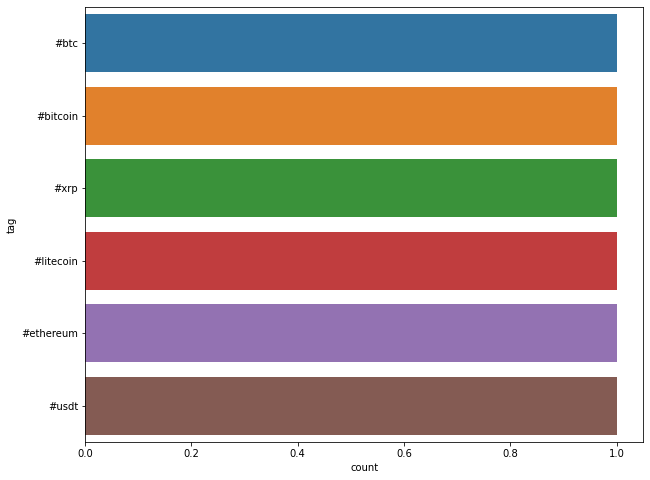

In [17]:
count = 0
while count < 10:
    
    time.sleep(3)
    top_10_tweets = sqlContext.sql('Select tag, count from tweets')
    top_10_df = top_10_tweets.toPandas()
    display.clear_output(wait=True)
    plt.figure(figsize = (10, 8))
    sns.barplot( x="count", y="tag", data=top_10_df)
    plt.show()
    count = count + 1

In [18]:
ssc.stop()

# END